In [58]:
import os
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from torchvision import datasets
from torchvision import transforms

from tqdm import tqdm

print("Pytorch version : %s"%(torch.__version__))

Pytorch version : 1.7.0


In [59]:
# Convert images to tensors
transform = transforms.Compose([transforms.ToTensor()])
batchsize = 10000

# Load training and testing datasets
TrainSet = datasets.MNIST(root="../downloads/MNIST", train=True, download=True, transform=transform)
TrainLoader = torch.utils.data.DataLoader(TrainSet, batch_size = batchsize, shuffle=True, num_workers=0)
TestSet = datasets.MNIST(root="../downloads/MNIST", train=False, download=True, transform=transform)
TestLoader = torch.utils.data.DataLoader(TestSet, batch_size = batchsize, shuffle=True, num_workers=0)

classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

In [60]:
print(TestSet.data.size())

torch.Size([10000, 28, 28])


In [61]:
use_gpu = torch.cuda.is_available()
if(use_gpu):
    device = "cuda"
    print(" GPU detected!")
else:
    device = "cpu"
    print(" GPU not detected")

 GPU detected!


In [70]:
class generator_net(nn.Module):
    def __init__(self, inp_dim, hidden_dim, out_dim):
        super(generator_net, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(inp_dim, hidden_dim),            nn.LeakyReLU(0.2))
        self.fc2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim*2),       nn.LeakyReLU(0.2))
        self.fc3 = nn.Sequential(nn.Linear(hidden_dim*2, hidden_dim*4),     nn.LeakyReLU(0.2))
        self.fc4 = nn.Linear(hidden_dim*4, out_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return torch.tanh(x)

class discriminator_net(nn.Module):
    def __init__(self, inp_dim, hidden_dim):
        super(discriminator_net, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(inp_dim, hidden_dim*4),          nn.LeakyReLU(0.2),  nn.Dropout(0.2))
        self.fc2 = nn.Sequential(nn.Linear(hidden_dim*4, hidden_dim*2),     nn.LeakyReLU(0.2),  nn.Dropout(0.2))
        self.fc3 = nn.Sequential(nn.Linear(hidden_dim*2, hidden_dim),       nn.LeakyReLU(0.2),  nn.Dropout(0.2))
        self.fc4 = nn.Linear(hidden_dim, 1)

        # self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1), nn.LeakyReLU(0.2))
        # self.conv2 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=9, kernel_size=3, padding=1), nn.LeakyReLU(0.2))
        # self.fc1   = nn.Sequential(nn.Linear(9*7*7, 50),  nn.ReLU())
        # self.fc2   = nn.Linear(50, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        # x = x.view(-1, 1, 28, 28)
        # x = F.max_pool2d(self.conv1(x), 2)
        # x = F.max_pool2d(self.conv2(x), 2)
        # x = x.view(-1, 9*7*7)
        # x = self.fc1(x)
        # x = F.dropout(x, 0.2)
        # x = self.fc2(x)
        # x = F.dropout(x, 0.2)

        return torch.sigmoid(x)

In [71]:
help(F.dropout)

Help on function dropout in module torch.nn.functional:

dropout(input, p=0.5, training=True, inplace=False)
    During training, randomly zeroes some of the elements of the input
    tensor with probability :attr:`p` using samples from a Bernoulli
    distribution.
    
    See :class:`~torch.nn.Dropout` for details.
    
    Args:
        p: probability of an element to be zeroed. Default: 0.5
        training: apply dropout if is ``True``. Default: ``True``
        inplace: If set to ``True``, will do this operation in-place. Default: ``False``



In [72]:
z_dim = 100
mnist_dim = TrainSet.train_data.size(1) * TrainSet.train_data.size(2)

gen_net = generator_net(z_dim, 256, mnist_dim).to(device)
dis_net = discriminator_net(mnist_dim, 256).to(device)

/home/ashwin/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [73]:
print(gen_net)
print(dis_net)

generator_net(
  (fc1): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (fc2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (fc3): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)
discriminator_net(
  (conv1): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=441, out_features=50, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


In [79]:
criterion = nn.BCELoss()

gen_optim = optim.Adam(gen_net.parameters(), lr=1e-2)
dis_optim = optim.Adam(dis_net.parameters(), lr=1e-4)

In [80]:
def dis_train(inp):
    dis_net.zero_grad()

    num_samples = inp.shape[0]
    # Forward pass of discriminator on real data
    x_real = inp.view(-1, mnist_dim).to(device)
    y_real = torch.ones(num_samples, 1).to(device)

    out_real = dis_net(x_real)

    error_real = criterion(out_real, y_real)

    # Forward pass of discriminator on generated data
    x_gen  = gen_net(torch.randn(num_samples, z_dim).to(device))
    y_gen  = torch.zeros(num_samples, 1).to(device)

    out_gen = dis_net(x_gen)

    error_gen = criterion(out_gen, y_gen)

    dis_error = error_gen + error_real
    dis_error.backward()

    dis_optim.step()

    print(error_gen.item(), error_real.item(), dis_error.item())
    return dis_error.item()

In [81]:
def gen_train():
    gen_net.zero_grad()

    x = torch.randn(batchsize, z_dim).to(device)
    y = torch.ones(batchsize, 1).to(device)

    gen_out = gen_net(x)
    dis_out = dis_net(gen_out)

    gen_error = criterion(dis_out, y)

    gen_error.backward()
    gen_optim.step()

    return gen_error.item()

  0%|          | 0/50 [00:00<?, ?it/s]

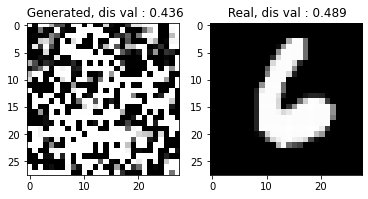

0.6049168705940247 0.7058191299438477 1.3107359409332275
0.6038753986358643 0.7063766121864319 1.3102519512176514
0.6017060279846191 0.7062495946884155 1.3079556226730347
0.6003766655921936 0.7065685987472534 1.3069453239440918
0.5981338024139404 0.706840455532074 1.3049743175506592
0.5959256291389465 0.707362949848175 1.3032885789871216
0.5929883122444153 0.7078981995582581 1.3008865118026733
0.5912562608718872 0.7082667946815491 1.299523115158081
0.589093804359436 0.7083494067192078 1.297443151473999
0.5864115357398987 0.7091172933578491 1.2955288887023926
0.5841802358627319 0.7094237804412842 1.2936040163040161
0.5830546021461487 0.7097646594047546 1.2928192615509033
0.579613447189331 0.710202157497406 1.2898156642913818
0.5804125070571899 0.7104141712188721 1.290826678276062
0.5780161023139954 0.7106856107711792 1.2887017726898193
0.575666069984436 0.7109766006469727 1.2866426706314087
0.5752601027488708 0.711287260055542 1.2865474224090576
0.5709971785545349 0.712082028388977 1.28

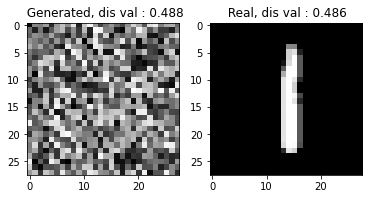

0.6180596947669983 0.7175403237342834 1.3356000185012817
0.6167125105857849 0.718166708946228 1.3348791599273682
0.6152962446212769 0.718532919883728 1.3338291645050049
0.6134746670722961 0.7191644310951233 1.3326390981674194
0.6124010682106018 0.7197827696800232 1.332183837890625
0.610580563545227 0.7205607295036316 1.3311412334442139
0.6096915602684021 0.7216727137565613 1.3313642740249634
0.6061123609542847 0.7213232517242432 1.3274356126785278
0.6051132678985596 0.7222025990486145 1.3273158073425293
0.6038172245025635 0.7223596572875977 1.3261768817901611
0.6011397838592529 0.723724365234375 1.324864149093628
0.5992072224617004 0.7246721386909485 1.323879361152649
0.5975353717803955 0.724973201751709 1.3225085735321045
0.5967319011688232 0.7255818247795105 1.3223137855529785
0.5936077237129211 0.7269074320793152 1.3205151557922363
0.592185378074646 0.7271667718887329 1.319352149963379
0.5890938639640808 0.7272521257400513 1.3163459300994873
0.5875338912010193 0.7280539870262146 1.3

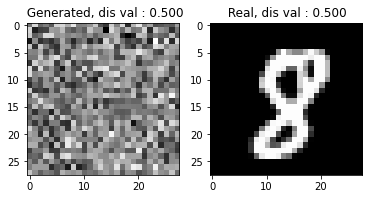

0.662409245967865 0.7347390055656433 1.3971482515335083
0.6616511344909668 0.7348238229751587 1.3964749574661255
0.6612587571144104 0.7346493005752563 1.3959081172943115
0.6606669425964355 0.734377920627594 1.3950448036193848
0.660991907119751 0.7341147065162659 1.395106554031372
0.6611073017120361 0.7339504957199097 1.3950577974319458
0.6608167886734009 0.7329251170158386 1.3937418460845947
0.6611570119857788 0.7326170802116394 1.3937740325927734
0.6607378721237183 0.7321435213088989 1.3928813934326172
0.6611269116401672 0.7315495014190674 1.3926763534545898
0.6614299416542053 0.7299648523330688 1.391394853591919
0.6620666980743408 0.7297711968421936 1.3918378353118896
0.6621648073196411 0.7290856838226318 1.391250491142273
0.662883460521698 0.7284234166145325 1.3913068771362305
0.6628241539001465 0.7277637720108032 1.3905879259109497
0.6633375883102417 0.7275752425193787 1.3909127712249756
0.6631680727005005 0.7258504033088684 1.3890185356140137
0.664260745048523 0.7251356244087219 1

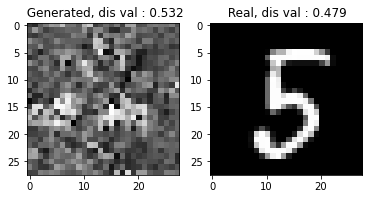

0.7059872150421143 0.7149537205696106 1.42094087600708
0.7068397998809814 0.7132409811019897 1.4200807809829712
0.7069071531295776 0.7131429314613342 1.4200501441955566
0.7075614333152771 0.7128822207450867 1.4204436540603638
0.7070655226707458 0.7123662829399109 1.4194318056106567
0.7068811655044556 0.7121943235397339 1.4190754890441895
0.7063748836517334 0.7114859819412231 1.4178608655929565
0.7061713933944702 0.7117542624473572 1.4179255962371826
0.7053072452545166 0.7111009359359741 1.4164081811904907
0.7045277953147888 0.7111247181892395 1.4156525135040283
0.7041352391242981 0.7109643220901489 1.4150996208190918
0.703312337398529 0.7101884484291077 1.4135007858276367
0.7026532292366028 0.7111296057701111 1.4137828350067139
0.7018729448318481 0.7111587524414062 1.4130316972732544
0.7005820274353027 0.7105532288551331 1.411135196685791
0.7001023292541504 0.711230993270874 1.4113333225250244
0.698348343372345 0.7111607789993286 1.4095091819763184
0.6978781819343567 0.7111237645149231

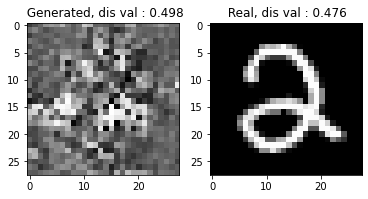

0.7004258036613464 0.7125853300094604 1.413011074066162
0.6988763213157654 0.7127673029899597 1.411643624305725
0.697658360004425 0.7124150395393372 1.4100733995437622
0.6974692344665527 0.7129030823707581 1.410372257232666
0.6965513229370117 0.7125418782234192 1.4090931415557861
0.6955812573432922 0.7128461003303528 1.408427357673645
0.6943036317825317 0.7132329940795898 1.4075366258621216
0.6935986876487732 0.7134953141212463 1.4070940017700195
0.692582905292511 0.713991105556488 1.406574010848999
0.6914284229278564 0.7141613960266113 1.4055898189544678
0.6909359693527222 0.7143567204475403 1.4052927494049072
0.689407229423523 0.7146945595741272 1.404101848602295
0.6882549524307251 0.7150044441223145 1.4032593965530396
0.6877140402793884 0.7154138088226318 1.403127908706665
0.6864007115364075 0.7155146598815918 1.4019153118133545
0.6859045624732971 0.715386688709259 1.4012912511825562
0.6848459839820862 0.7159159779548645 1.4007619619369507
0.6839631795883179 0.7157245874404907 1.399

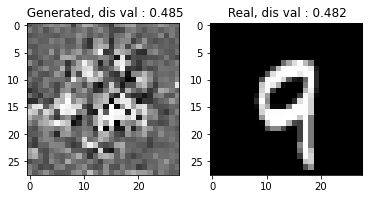

0.67449951171875 0.7181586027145386 1.3926581144332886
0.6739351153373718 0.7180532813072205 1.3919883966445923
0.6730026006698608 0.7181337475776672 1.3911364078521729
0.6716122627258301 0.7181927561759949 1.3898050785064697
0.6713898181915283 0.7191600203514099 1.390549898147583
0.6708085536956787 0.7185883522033691 1.3893969058990479
0.6692996025085449 0.7192134857177734 1.3885130882263184
0.6688757538795471 0.7192285060882568 1.3881042003631592
0.6679987907409668 0.7201676368713379 1.3881664276123047
0.6675248146057129 0.7195627689361572 1.3870875835418701
0.6658943891525269 0.7201408743858337 1.3860352039337158
0.6659835577011108 0.7196199893951416 1.3856035470962524
0.6642284989356995 0.7202872037887573 1.3845157623291016
0.663080632686615 0.7203838229179382 1.3834644556045532
0.6624192595481873 0.7206392288208008 1.3830585479736328
0.6620729565620422 0.7211466431617737 1.383219599723816
0.6615827679634094 0.7210361361503601 1.3826189041137695
0.6604688167572021 0.721254825592041

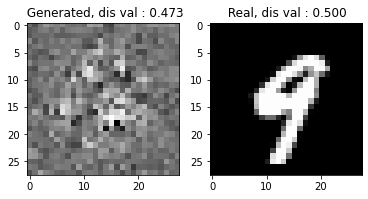

0.6695262789726257 0.7221396565437317 1.3916659355163574
0.6702313423156738 0.722496747970581 1.3927280902862549
0.6694579124450684 0.7227005958557129 1.3921585083007812
0.6699514389038086 0.7215651869773865 1.3915166854858398
0.6702893972396851 0.7218236923217773 1.3921130895614624
0.6704095602035522 0.7214304208755493 1.3918399810791016
0.6705700755119324 0.721061110496521 1.3916311264038086
0.6711350083351135 0.7195965647697449 1.3907315731048584
0.6708964109420776 0.7193981409072876 1.3902945518493652
0.6716369986534119 0.7185791730880737 1.3902161121368408
0.6719424724578857 0.7182912230491638 1.3902337551116943
0.6724230051040649 0.7164248824119568 1.388847827911377
0.672697126865387 0.7160062193870544 1.3887033462524414
0.6732507348060608 0.7151570916175842 1.388407826423645
0.6739256381988525 0.7137520909309387 1.3876776695251465
0.6747548580169678 0.7131581902503967 1.3879129886627197
0.6751461625099182 0.7120742797851562 1.3872203826904297
0.6758977174758911 0.711910188198089

KeyboardInterrupt: 

In [82]:
iterations = 50
dis_factor = 5      # Number of times discriminator is trained than the generator

num_batch  = TrainSet.data.size()[0] // batchsize

debug = True

idx = 0

gen_hist = []
dis_hist = []

for epoch in tqdm(range(iterations)):
    gen_runningloss = 0
    dis_runningloss = 0

    if(debug):
        gen_inp  = torch.randn(1, z_dim).to(device)
        real_img = (list(TrainLoader)[0])[0].view(-1, 28*28)[0].to(device)
        gen_img  = gen_net(gen_inp)

        dis_gout = dis_net(gen_img).cpu()
        dis_rout = dis_net(real_img).cpu()

        plt.subplot(121)
        plt.imshow(gen_img.cpu().detach().view(28,28).numpy(), cmap='gray')
        plt.title(" Generated, dis val : %.3f"%(dis_gout))

        plt.subplot(122)
        plt.imshow(real_img.cpu().detach().view(28,28).numpy(), cmap='gray')
        plt.title(" Real, dis val : %.3f"%(dis_rout))

        plt.show()

    for i in range(dis_factor):
        if(i != 0 and dis_runningloss < 0.5):
            break
        for data in TrainLoader:
            inputs, data = data

            dis_loss = dis_train(inputs)

            dis_runningloss += dis_loss
            dis_hist.append((idx, dis_loss))

            idx

    for i in range(num_batch):
        gen_loss = gen_train()

        gen_runningloss += gen_loss
        gen_hist.append((idx, gen_loss))

        idx += 1

    gen_runningloss /= num_batch
    dis_runningloss /= (num_batch * dis_factor)
        
    if(debug):
       print(" Gen loss : %5.1f, Dis loss : %5.1f"%(gen_runningloss, dis_runningloss))
     
    if(epoch % 10 == 9):        
        print(" Iteration %3d/%3d, gen loss %15.1f, disloss %.1f"%(epoch+1, iterations, gen_runningloss, dis_runningloss))

print(" Finished training")

In [ ]:
plt.plot(list(zip(*gen_hist))[0], list(zip(*gen_hist))[1], label="Generator")
plt.plot(list(zip(*dis_hist))[0], list(zip(*dis_hist))[1], label="Discriminator")
plt.legend()
plt.show()

In [ ]:
for i in range(10):
    gen_inp = torch.randn(1, z_dim).to(device)
    gen_out = gen_net(gen_inp)

    plt.imshow(gen_out.cpu().view(28, 28).detach().numpy(), cmap='gray')
    plt.title(" Generated image")
    plt.show()